In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Compute WGCNA

1. Load data

In [2]:
# Load the AnnData object from the .h5ad file
adata = sc.read("PBMC_combined_annotated_3data.h5ad") #this data is log1p, not scaled
adata = adata[adata.obs['source'] == 'SSTX'].copy()


2. Select certain biotypes to include

In [3]:
coding_mask = adata.var["biotype"] == "protein_coding"
noncoding_mask = adata.var["biotype"].isin([
    "lncRNA", "miRNA", "snoRNA", "snRNA", "scaRNA", "misc_RNA", "tRNA", "histone_RNA"
])
selected_mask = coding_mask | noncoding_mask
adata_selected = adata[:, selected_mask].copy()

3. Pseudobulk

In [4]:
cell_types = adata.obs["cell_type_lvl2"].unique()
pseudobulk = []

for ct in cell_types:
    mask = adata.obs["cell_type_lvl2"] == ct
    counts = adata_selected[mask].X

    summed = counts.sum(axis=0)
    summed = summed.A1 if hasattr(summed, "A1") else np.ravel(summed)  # ensure 1D

    pseudobulk.append(pd.Series(summed, index=adata_selected.var_names, name=ct))

# Combine into dataframe
df_expr = pd.concat(pseudobulk, axis=1)
# shape: genes (rows) × cell types (columns)
# Make sure it's a DataFrame
df_expr.shape


(36849, 15)

In [5]:
#coding_genes = adata_selected.var_names[coding_mask[selected_mask]]
#noncoding_genes = adata_selected.var_names[noncoding_mask[selected_mask]]

# Compute pairwise correlation: noncoding vs. coding
#df_corr = df_expr.loc[noncoding_genes].T.corrwith(df_expr.loc[coding_genes].T.mean(axis=0), axis=0)
#df_corr = df_corr.sort_values(ascending=False)


In [6]:
#df_coding = df_expr.loc[coding_genes]
#df_noncoding = df_expr.loc[noncoding_genes]

# Pearson correlation between noncoding and coding genes
#coding_noncoding_corr = df_noncoding.T.corrwith(df_coding.T, axis=0)


In [7]:
cor_matrix = df_expr.T.corr(method='pearson')

4. TOM

In [8]:
def compute_TOM(adj):
    # Convert everything to NumPy arrays first
    adj_array = adj.values
    degree = adj_array.sum(axis=1)

    # Matrix product
    product = adj_array @ adj_array

    # Compute TOM
    denom = np.minimum.outer(degree, degree) - adj_array + 1e-6
    tom_array = (product - adj_array) / denom

    # Set diagonal to 1
    np.fill_diagonal(tom_array, 1.0)

    # Convert back to DataFrame
    return pd.DataFrame(tom_array, index=adj.index, columns=adj.columns)



In [9]:
# Step 1: Compute variance across cell types
gene_variance = df_expr.var(axis=1)

# Step 2: Keep only genes with variance above a threshold
filtered_genes = gene_variance[gene_variance > 0.5].index  # you can adjust the threshold
df_expr_filtered = df_expr.loc[filtered_genes]
print(f"Filtered down to {df_expr_filtered.shape[0]} genes")


Filtered down to 31864 genes


In [10]:
# Step 3: Compute correlation and adjacency
cor_matrix = df_expr_filtered.T.corr().fillna(0)

beta = 6  # can try 4–8
adj_matrix = cor_matrix.abs() ** beta


# Step 4: Compute TOM
tom_matrix = compute_TOM(adj_matrix)


In [11]:
tom_matrix

,ENSG00000238009,ENSG00000239945,ENSG00000241860,ENSG00000241599,ENSG00000290385,ENSG00000291215,LINC01409,ENSG00000290784,FAM87B,LINC00115,...,U3-27,ENSG00000275110,MIR766,SNORA69,SNORD61,MIR505,SNORA70-5,MIR6858,SNORA36A,SNORA56
ENSG00000238009,1.000000,0.446671,0.661151,0.585002,0.638996,0.699640,0.691168,0.667120,0.702233,0.721659,...,0.591361,0.629241,0.651990,0.679747,0.097431,0.067018,0.394473,0.324558,0.217443,0.660450
ENSG00000239945,0.446671,1.000000,0.526930,0.447144,0.501390,0.700018,0.684890,0.638711,0.597039,0.664508,...,0.380077,0.643909,0.574545,0.622753,0.096927,0.165462,0.399023,0.380458,0.290552,0.603435
ENSG00000241860,0.661151,0.526930,1.000000,0.702099,0.698681,0.703398,0.697804,0.669588,0.718281,0.738820,...,0.714517,0.632021,0.659165,0.691786,0.070716,0.070136,0.428403,0.374566,0.245958,0.676984
ENSG00000241599,0.585002,0.447144,0.702099,1.000000,0.682150,0.694673,0.690158,0.663297,0.724296,0.740549,...,0.634969,0.622733,0.657359,0.695115,0.057414,0.052245,0.354875,0.307137,0.193837,0.679221
ENSG00000290385,0.638996,0.501390,0.698681,0.682150,1.000000,0.700235,0.695611,0.667509,0.723010,0.741217,...,0.695473,0.628147,0.661256,0.693305,0.063575,0.061510,0.401872,0.348771,0.225821,0.679675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MIR505,0.067018,0.165462,0.070136,0.052245,0.061510,0.242784,0.219747,0.206658,0.114374,0.156805,...,0.035375,0.241048,0.133989,0.161797,0.113598,1.000000,0.251824,0.337459,0.108542,0.138075
SNORA70-5,0.394473,0.399023,0.428403,0.354875,0.401872,0.659688,0.631331,0.611505,0.519390,0.576258,...,0.325158,0.613684,0.528667,0.558241,0.263880,0.251824,1.000000,0.428991,0.363222,0.517498
MIR6858,0.324558,0.380458,0.374566,0.307137,0.348771,0.627312,0.599589,0.568932,0.463276,0.536048,...,0.236791,0.589667,0.468931,0.518077,0.162576,0.337459,0.428991,1.000000,0.380191,0.482149
SNORA36A,0.217443,0.290552,0.245958,0.193837,0.225821,0.472129,0.441271,0.427175,0.317525,0.377305,...,0.141122,0.467779,0.341552,0.365079,0.050608,0.108542,0.363222,0.380191,1.000000,0.336082


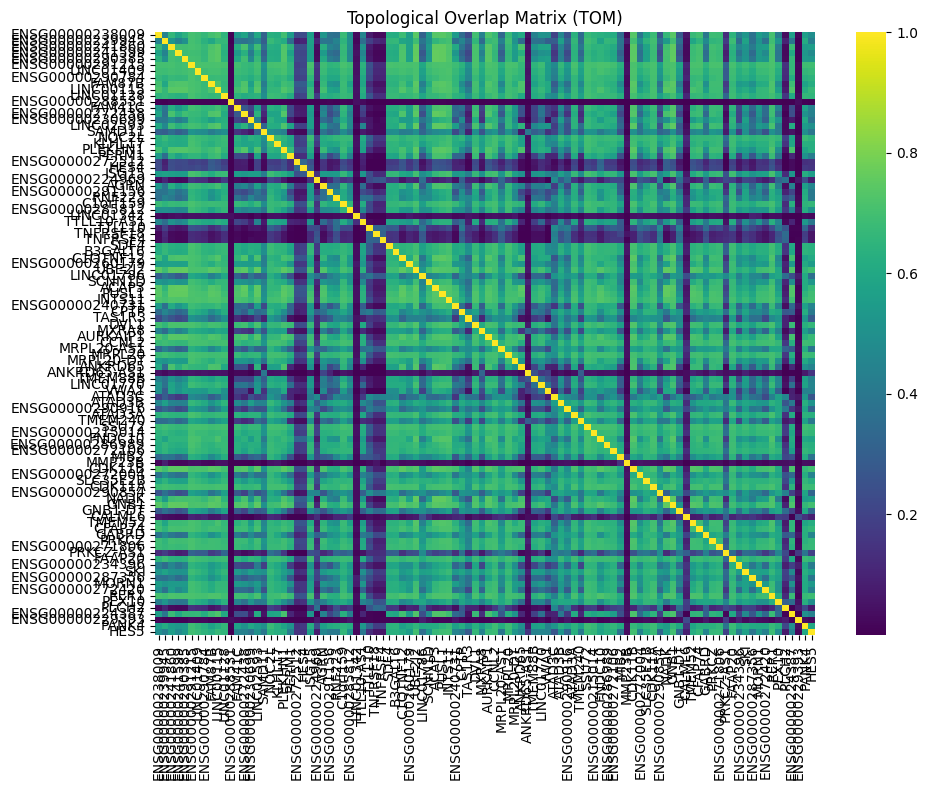

In [12]:
# Subset if it's very large
genes_to_plot = tom_matrix.index[:100]  # or filter by modules
subset = tom_matrix.loc[genes_to_plot, genes_to_plot]

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Topological Overlap Matrix (TOM)")
plt.tight_layout()
plt.show()

/home/users/isakova/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/users/isakova/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


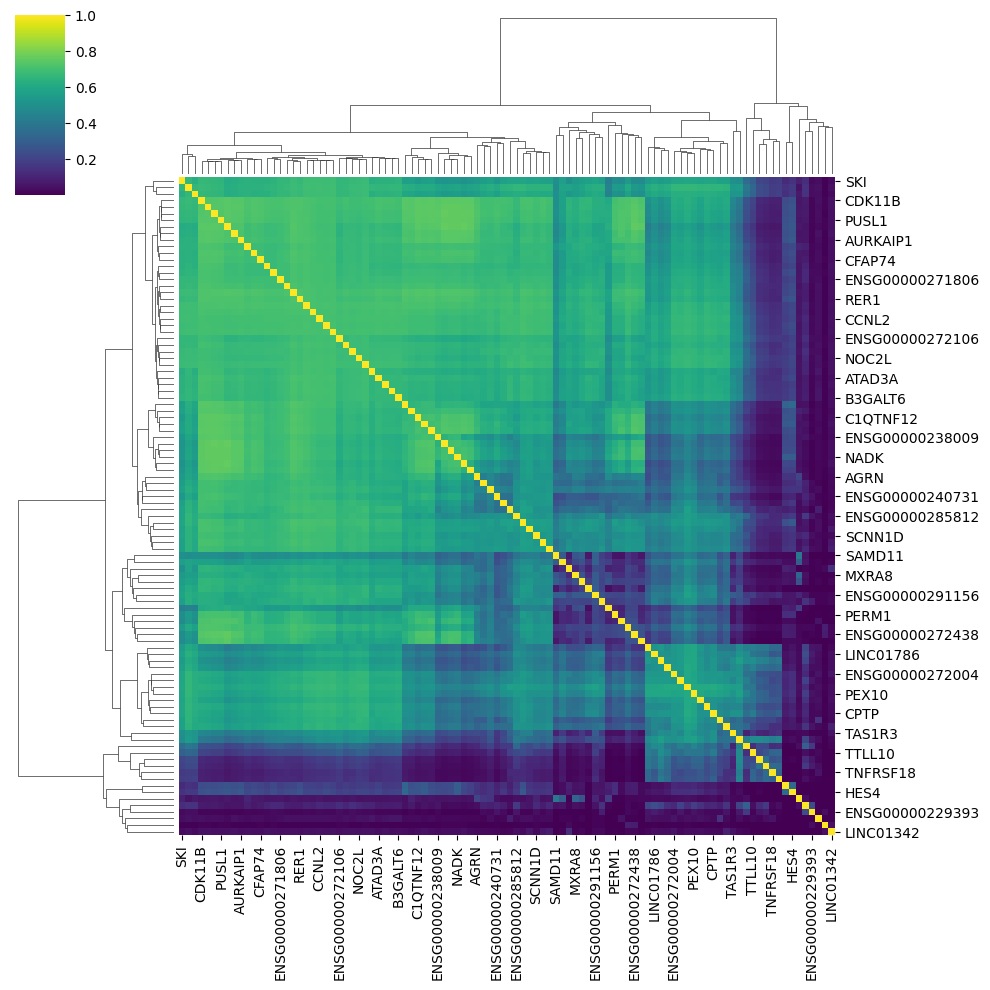

In [13]:
sns.clustermap(
    subset,
    cmap="viridis",
    metric="euclidean",
    method="average",
    figsize=(10, 10)
)


In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# Convert TOM to dissimilarity
dissimilarity = 1 - tom_matrix
dissimilarity = (dissimilarity + dissimilarity.T) / 2

condensed = squareform(dissimilarity)
Z = linkage(condensed, method='average')

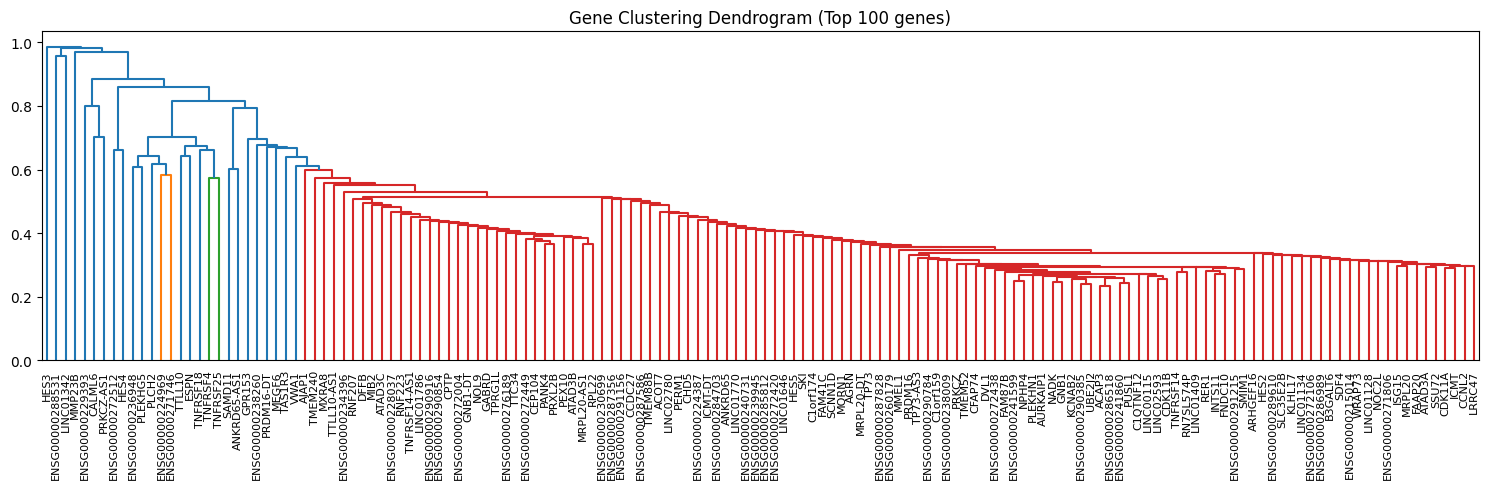

In [15]:
# Limit to a manageable subset for plotting
genes_to_plot = tom_matrix.index[:150]  # top 100 genes
tom_subset = tom_matrix.loc[genes_to_plot, genes_to_plot]


dissimilarity = 1 - tom_subset
dissimilarity = (dissimilarity + dissimilarity.T) / 2  # ensure symmetry
condensed = squareform(dissimilarity)
Z_subset = linkage(condensed, method='average')

plt.figure(figsize=(15, 5))
dendrogram(
    Z_subset,
    labels=genes_to_plot,  # or use None
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0.6
)
plt.title("Gene Clustering Dendrogram (Top 100 genes)")
plt.tight_layout()
plt.show()



5. Modules

In [16]:
from scipy.cluster.hierarchy import fcluster

for t in [0.2, 0.4, 0.6, 0.8, 1.0]:
    labels = fcluster(Z, t=t, criterion='distance')
    sizes = pd.Series(labels).value_counts()
    print(f"t={t:.1f} → {len(sizes)} modules | median size: {sizes.median()}")


t=0.2 → 31862 modules | median size: 1.0
t=0.4 → 15384 modules | median size: 1.0
t=0.6 → 3887 modules | median size: 1.0
t=0.8 → 301 modules | median size: 1.0
t=1.0 → 1 modules | median size: 31864.0


In [17]:
# Cut tree to form modules
module_labels = fcluster(Z, t=0.7, criterion="distance")

module_series = pd.Series(module_labels.astype(int), index=tom_matrix.index, name="module")
print("New number of modules:", module_series.nunique())

# Enforce a minimum module size of 30 genes
min_module_size = 10
module_sizes = module_series.value_counts()
valid_modules = module_sizes[module_sizes >= min_module_size].index

# Filter out small modules
module_series = module_series[module_series.isin(valid_modules)]

from sklearn.preprocessing import LabelEncoder

module_series = pd.Series(
    LabelEncoder().fit_transform(module_series),
    index=module_series.index,
    name="module"
)

New number of modules: 1395


In [18]:
module_series.nunique()

24

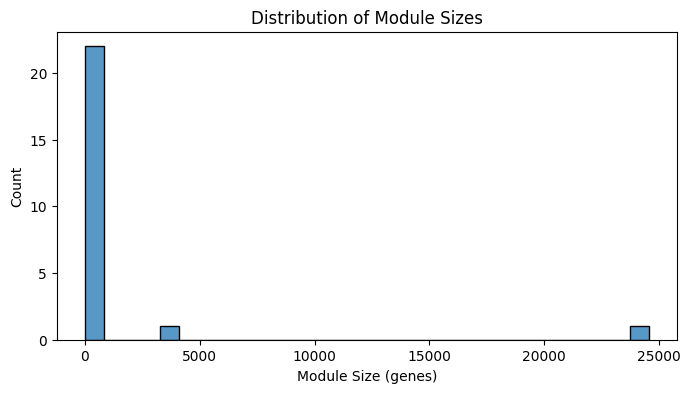

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt



module_sizes = module_series.value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(module_sizes, bins=30)
plt.xlabel("Module Size (genes)")
plt.title("Distribution of Module Sizes")
plt.show()


In [20]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import numpy as np
import pandas as pd

MAX_SUBMODULE_SIZE = 1000
MIN_SUBMODULE_SIZE = 10

# Recalculate current module sizes
module_sizes = module_series.value_counts()
large_modules = module_sizes[module_sizes > MAX_SUBMODULE_SIZE].index

next_label = module_series.max() + 1  # to assign new unique submodule IDs

for mod_id in large_modules:
    genes = module_series[module_series == mod_id].index
    print(f"Reclustering module {mod_id} with {len(genes)} genes...")

    tom_sub = tom_matrix.loc[genes, genes]
    diss_sub = 1 - tom_sub
    diss_sub = (diss_sub + diss_sub.T) / 2  # enforce symmetry
    np.fill_diagonal(diss_sub.values, 0)

    try:
        Z_sub = linkage(squareform(diss_sub), method="average")
        labels_sub = fcluster(Z_sub, t=0.5, criterion="distance")
        sub_series = pd.Series(labels_sub, index=genes)

        sub_sizes = sub_series.value_counts()
        kept = 0

        for sub_id, size in sub_sizes.items():
            gene_subset = sub_series[sub_series == sub_id].index
            if size >= MIN_SUBMODULE_SIZE:
                module_series.loc[gene_subset] = next_label
                next_label += 1
                kept += 1
            else:
                module_series.loc[gene_subset] = -1  # discard small submodules

        print(f"→ Created {kept} valid submodules (≥{MIN_SUBMODULE_SIZE} genes) from module {mod_id}")

    except Exception as e:
        print(f" Failed to recluster module {mod_id}: {e}")


Reclustering module 22 with 24552 genes...
→ Created 2 valid submodules (≥10 genes) from module 22
Reclustering module 21 with 4029 genes...
→ Created 8 valid submodules (≥10 genes) from module 21


In [21]:
module_series.nunique()

33

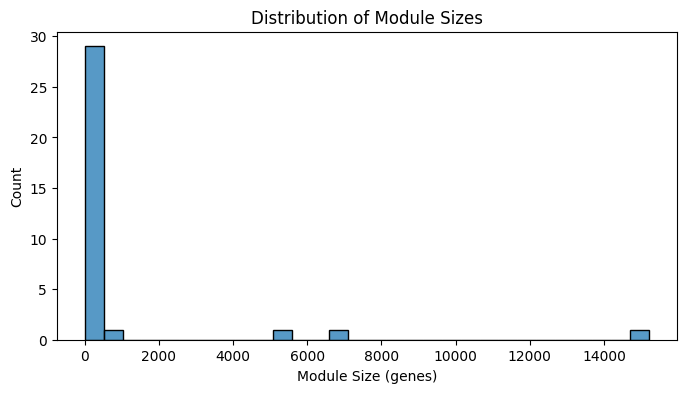

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

module_sizes = module_series.value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(module_sizes, bins=30)
plt.xlabel("Module Size (genes)")
plt.title("Distribution of Module Sizes")
plt.show()


In [23]:
# Step 3: Remove modules with more than 10,000 genes
max_module_size = 2000
module_sizes = module_series.value_counts()
huge_modules = module_sizes[module_sizes > max_module_size].index

# Remove huge modules
module_series = module_series[~module_series.isin(huge_modules)]

# Reassign new IDs again (optional but helpful for clarity)
module_series = pd.Series(
    LabelEncoder().fit_transform(module_series),
    index=module_series.index,
    name="module"
)

print("Final number of modules (after removing >10K gene ones):", module_series.nunique())


Final number of modules (after removing >10K gene ones): 30


In [24]:
from sklearn.decomposition import PCA


module_eigengenes = {}

for module_id in np.unique(module_series):
    genes_in_module = module_series[module_series == module_id].index

    # Skip empty or 1-gene modules (not valid for PCA)
    if len(genes_in_module) < 5:
        continue

    try:
        expr = df_expr.loc[genes_in_module].T  # cells × genes
        pca = PCA(n_components=1)
        eigengene = pca.fit_transform(expr)
        module_eigengenes[f"Module{module_id}"] = eigengene[:, 0]
    except Exception as e:
        print(f"Skipping Module {module_id} due to error: {e}")


df_eigengenes = pd.DataFrame(module_eigengenes, index=df_expr.columns)


In [25]:
coding_mask = adata.var["biotype"] == "protein_coding"
is_coding = df_expr.index.isin(adata.var_names[coding_mask])
gene_biotype = pd.Series(is_coding, index=df_expr.index)

# % coding genes per module
module_coding_fraction = module_series.groupby(module_series).apply(lambda mod: gene_biotype[mod.index].mean())
print(module_coding_fraction)

module
0     0.390244
1     0.388889
2     0.422642
3     0.500000
4     0.428571
5     0.650000
6     0.507109
7     0.616279
8     0.200000
9     0.444444
10    0.571429
11    0.291667
12    0.361111
13    0.303333
14    0.181818
15    0.276316
16    0.448276
17    0.153846
18    0.296296
19    0.312500
20    0.492308
21    0.525253
22    0.672535
23    0.522388
24    0.577540
25    0.500000
26    0.782609
27    0.521739
28    0.769231
29    0.636364
Name: module, dtype: float64


In [26]:
# Make sure gene biotype info is aligned with module genes
biotypes = adata.var["biotype"]
biotypes = biotypes.reindex(module_series.index)

# Define non-coding biotypes
noncoding_types = ["lncRNA", "miRNA", "snoRNA", "snRNA", "scaRNA", "misc_RNA", "tRNA", "histone_RNA"]
is_noncoding = biotypes.isin(noncoding_types)

In [27]:
module_noncoding_fraction = module_series.groupby(module_series).apply(
    lambda genes: is_noncoding[genes.index].mean()
)

# Also get number of genes per module for context
module_sizes = module_series.value_counts().sort_index()


/tmp/ipykernel_2220/1334766869.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


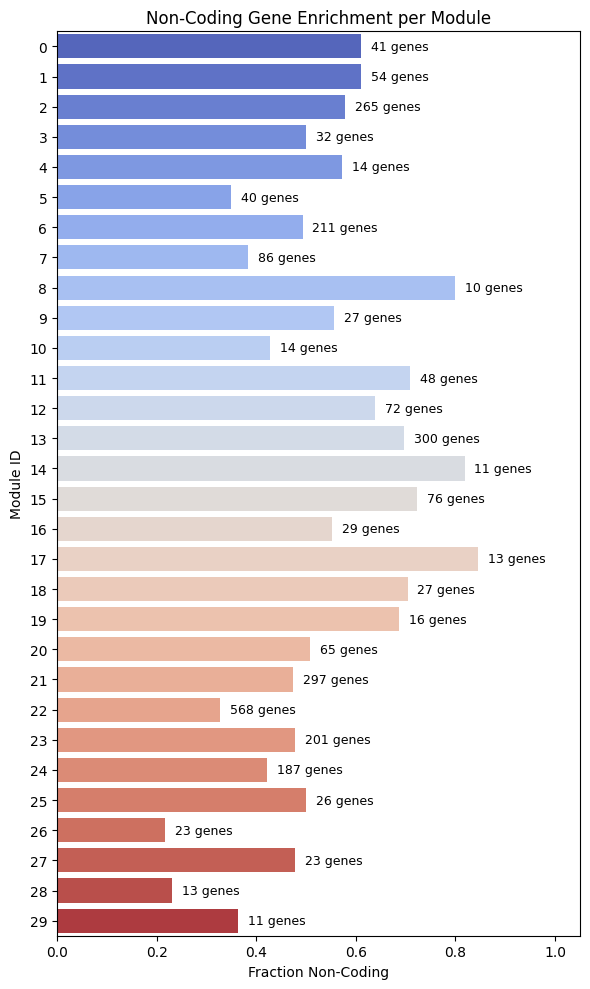

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 10))  # adjust width x height for horizontal layout

sns.barplot(
    y=module_noncoding_fraction.index.astype(str),
    x=module_noncoding_fraction.values,
    palette="coolwarm"
)

for i, n in enumerate(module_sizes.values):
    plt.text(module_noncoding_fraction[i] + 0.02, i, f"{n} genes", va="center", fontsize=9)

plt.xlabel("Fraction Non-Coding")
plt.ylabel("Module ID")
plt.title("Non-Coding Gene Enrichment per Module")
plt.xlim(0, 1.05)
plt.tight_layout()
plt.savefig("Non-Coding_Gene_Enrichment_per_Module.pdf", bbox_inches="tight")
plt.show()


/tmp/ipykernel_2220/2515961185.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


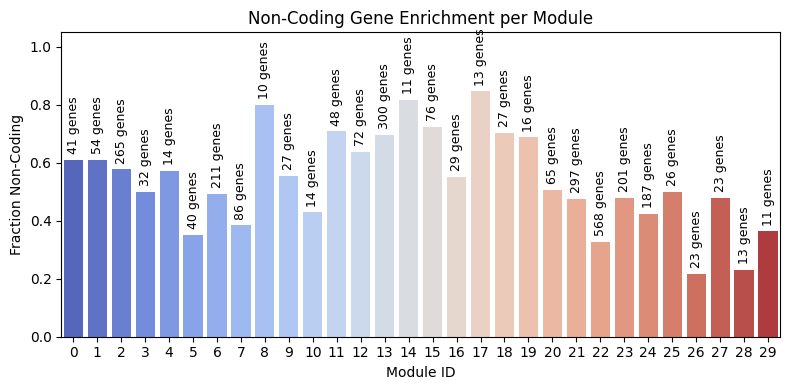

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))  # wider than tall for vertical bars

sns.barplot(
    x=module_noncoding_fraction.index.astype(str),
    y=module_noncoding_fraction.values,
    palette="coolwarm"
)

# Annotate number of genes above each bar
for i, (val, n) in enumerate(zip(module_noncoding_fraction.values, module_sizes.values)):
    plt.text(
        i, val + 0.02, f"{n} genes",
        ha="center", va="bottom",
        fontsize=9,
        rotation=90
    )


plt.ylabel("Fraction Non-Coding")
plt.xlabel("Module ID")
plt.title("Non-Coding Gene Enrichment per Module")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


In [30]:
# Get module IDs with >50% non-coding genes
noncoding_enriched_modules = module_noncoding_fraction[module_noncoding_fraction > 0.15].index

# List genes in each
for module_id in noncoding_enriched_modules:
    genes = module_series[module_series == module_id].index.tolist()
    print(f"\nModule {module_id} ({len(genes)} genes):")
    for gene in genes:
        biotype = adata.var.loc[gene, "biotype"] if gene in adata.var_names else "unknown"
        print(f"  {gene} ({biotype})")



Module 0 (41 genes):
  ENSG00000288531 (lncRNA)
  CAMTA1-AS2 (lncRNA)
  IFNLR1 (protein_coding)
  BMP8A (protein_coding)
  ROR1 (protein_coding)
  LINC01650 (lncRNA)
  GEN1 (protein_coding)
  ENSG00000289134 (lncRNA)
  ANK2 (protein_coding)
  ANK2-AS1 (lncRNA)
  GALNTL6 (protein_coding)
  ENSG00000234540 (lncRNA)
  ENSG00000291342 (lncRNA)
  LINC01013 (lncRNA)
  SMOC2 (protein_coding)
  ENSG00000287554 (lncRNA)
  WNT16 (protein_coding)
  PIP (protein_coding)
  ENSG00000287740 (lncRNA)
  DNAJC5B (protein_coding)
  ENSG00000271046 (lncRNA)
  MYO3A (protein_coding)
  ENSG00000236154 (lncRNA)
  ARHGAP42 (protein_coding)
  SOX5 (protein_coding)
  SOX5-AS1 (lncRNA)
  ENSG00000257191 (lncRNA)
  ENSG00000255595 (lncRNA)
  PCDH9-AS3 (lncRNA)
  PCDH9-AS4 (lncRNA)
  ENSG00000285588 (lncRNA)
  ENSG00000258386 (lncRNA)
  ENSG00000261207 (lncRNA)
  LINC02137 (lncRNA)
  ENSG00000266283 (lncRNA)
  PPP1R14A (protein_coding)
  KLK1 (protein_coding)
  KLKP1 (lncRNA)
  NLRP4 (protein_coding)
  ENSG000002

In [31]:
# Step 1: Get number of genes per module
module_sizes = module_series.value_counts()

# Step 2: Filter for modules with >20% non-coding AND ≥3 genes
eligible_modules = module_noncoding_fraction[
    (module_noncoding_fraction > 0.2) & 
    (module_sizes >= 3)
].index

# Step 3: Write genes in filtered modules to a text file
with open("PBMC_filtered_modules_genes.txt", "w") as f:
    for module_id in eligible_modules:
        genes = module_series[module_series == module_id].index.tolist()
        f.write(f"\nModule {module_id} ({len(genes)} genes):\n")
        for gene in genes:
            biotype = adata.var.loc[gene, "biotype"] if gene in adata.var_names else "unknown"
            f.write(f"  {gene} ({biotype})\n")


In [32]:
module_sizes = module_series.value_counts()
print(module_sizes.describe())

count     30.000000
mean      93.333333
std      126.910594
min       10.000000
25%       17.750000
50%       36.000000
75%       83.500000
max      568.000000
Name: count, dtype: float64


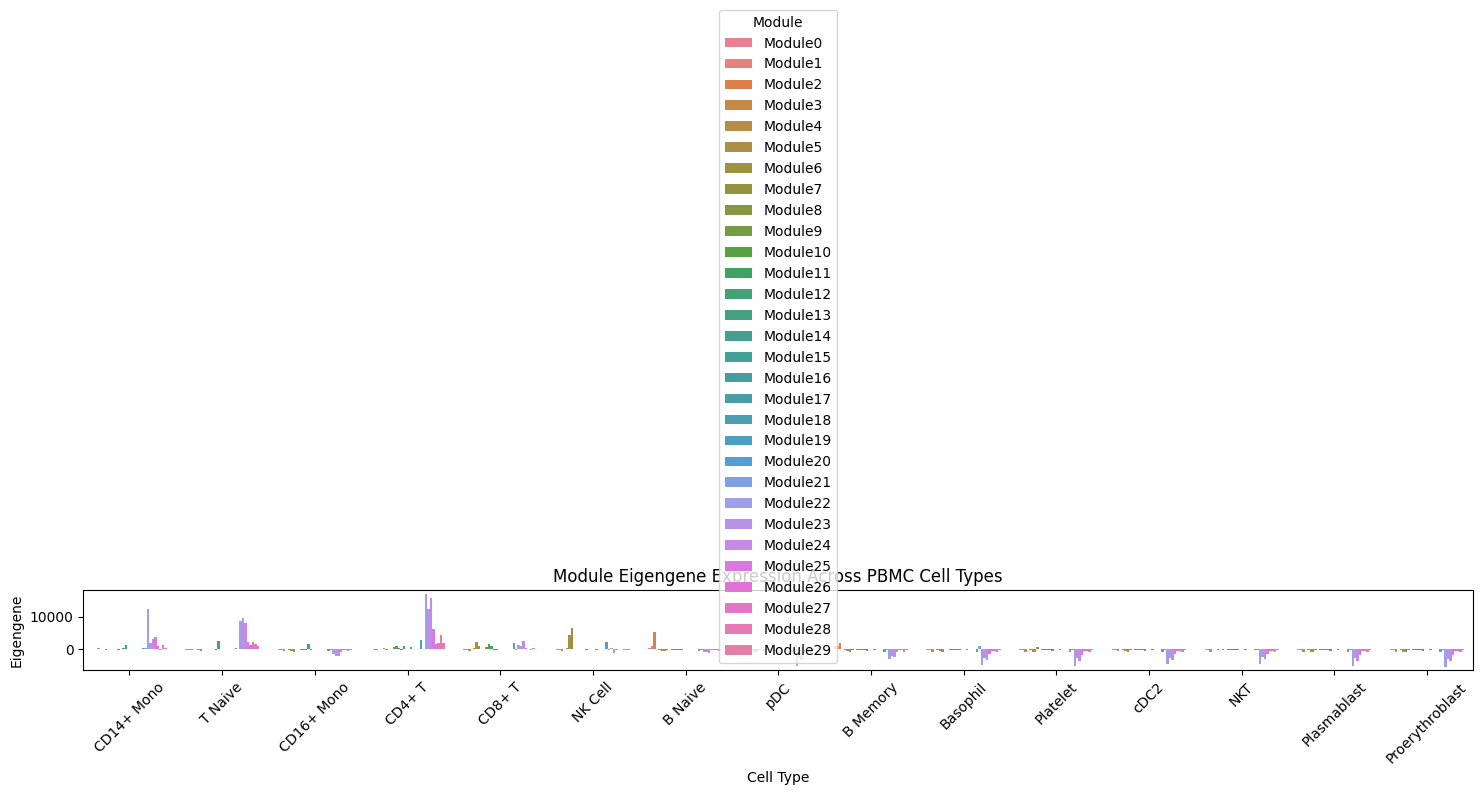

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick non-coding enriched modules (e.g., top 3)
modules_to_plot = [f"Module{m}" for m in noncoding_enriched_modules[:40] if f"Module{m}" in df_eigengenes.columns]

# Melt for plotting
df_long = df_eigengenes[modules_to_plot].reset_index().melt(id_vars="index", var_name="Module", value_name="Eigengene")
df_long.rename(columns={"index": "Cell Type"}, inplace=True)

plt.figure(figsize=(15, 5))
sns.barplot(data=df_long, x="Cell Type", y="Eigengene", hue="Module")
plt.xticks(rotation=45)
plt.title("Module Eigengene Expression Across PBMC Cell Types")
plt.tight_layout()
plt.show()


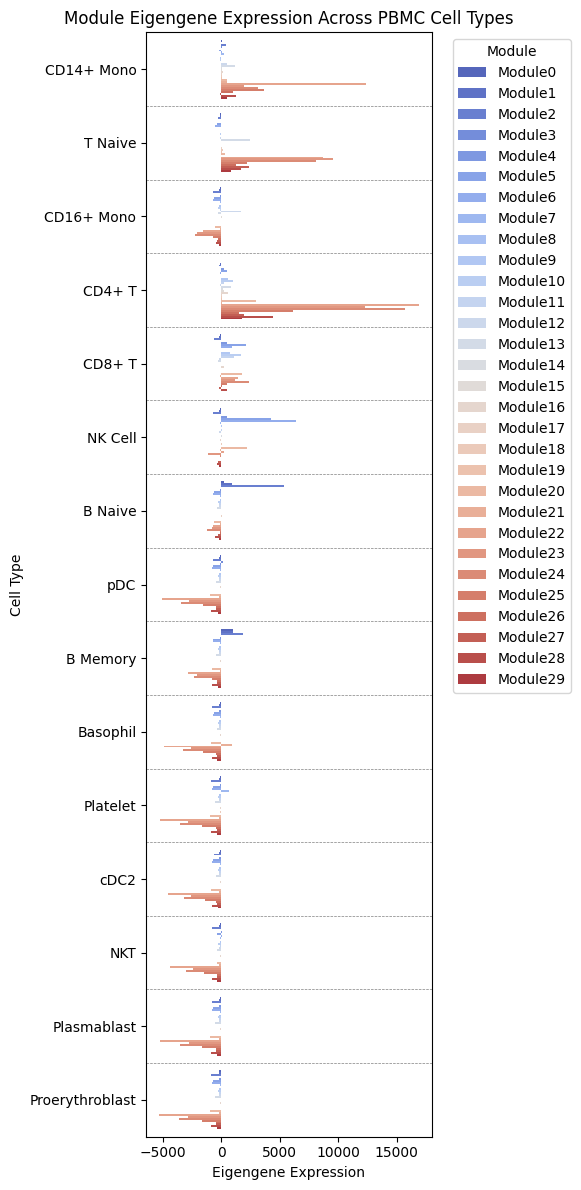

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick non-coding enriched modules
modules_to_plot = [f"Module{m}" for m in noncoding_enriched_modules[:40] if f"Module{m}" in df_eigengenes.columns]

# Melt for plotting
df_long = df_eigengenes[modules_to_plot].reset_index().melt(id_vars="index", var_name="Module", value_name="Eigengene")
df_long.rename(columns={"index": "Cell Type"}, inplace=True)

plt.figure(figsize=(6, 12))
ax = sns.barplot(
    data=df_long,
    x="Eigengene",
    y="Cell Type",
    hue="Module",
    palette="coolwarm"
)

plt.title("Module Eigengene Expression Across PBMC Cell Types")
plt.xlabel("Eigengene Expression")
plt.ylabel("Cell Type")
plt.legend(title="Module", bbox_to_anchor=(1.05, 1), loc='upper left')

yticks = np.array(ax.get_yticks())
midpoints = (yticks[:-1] + yticks[1:]) / 2


for y in midpoints:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


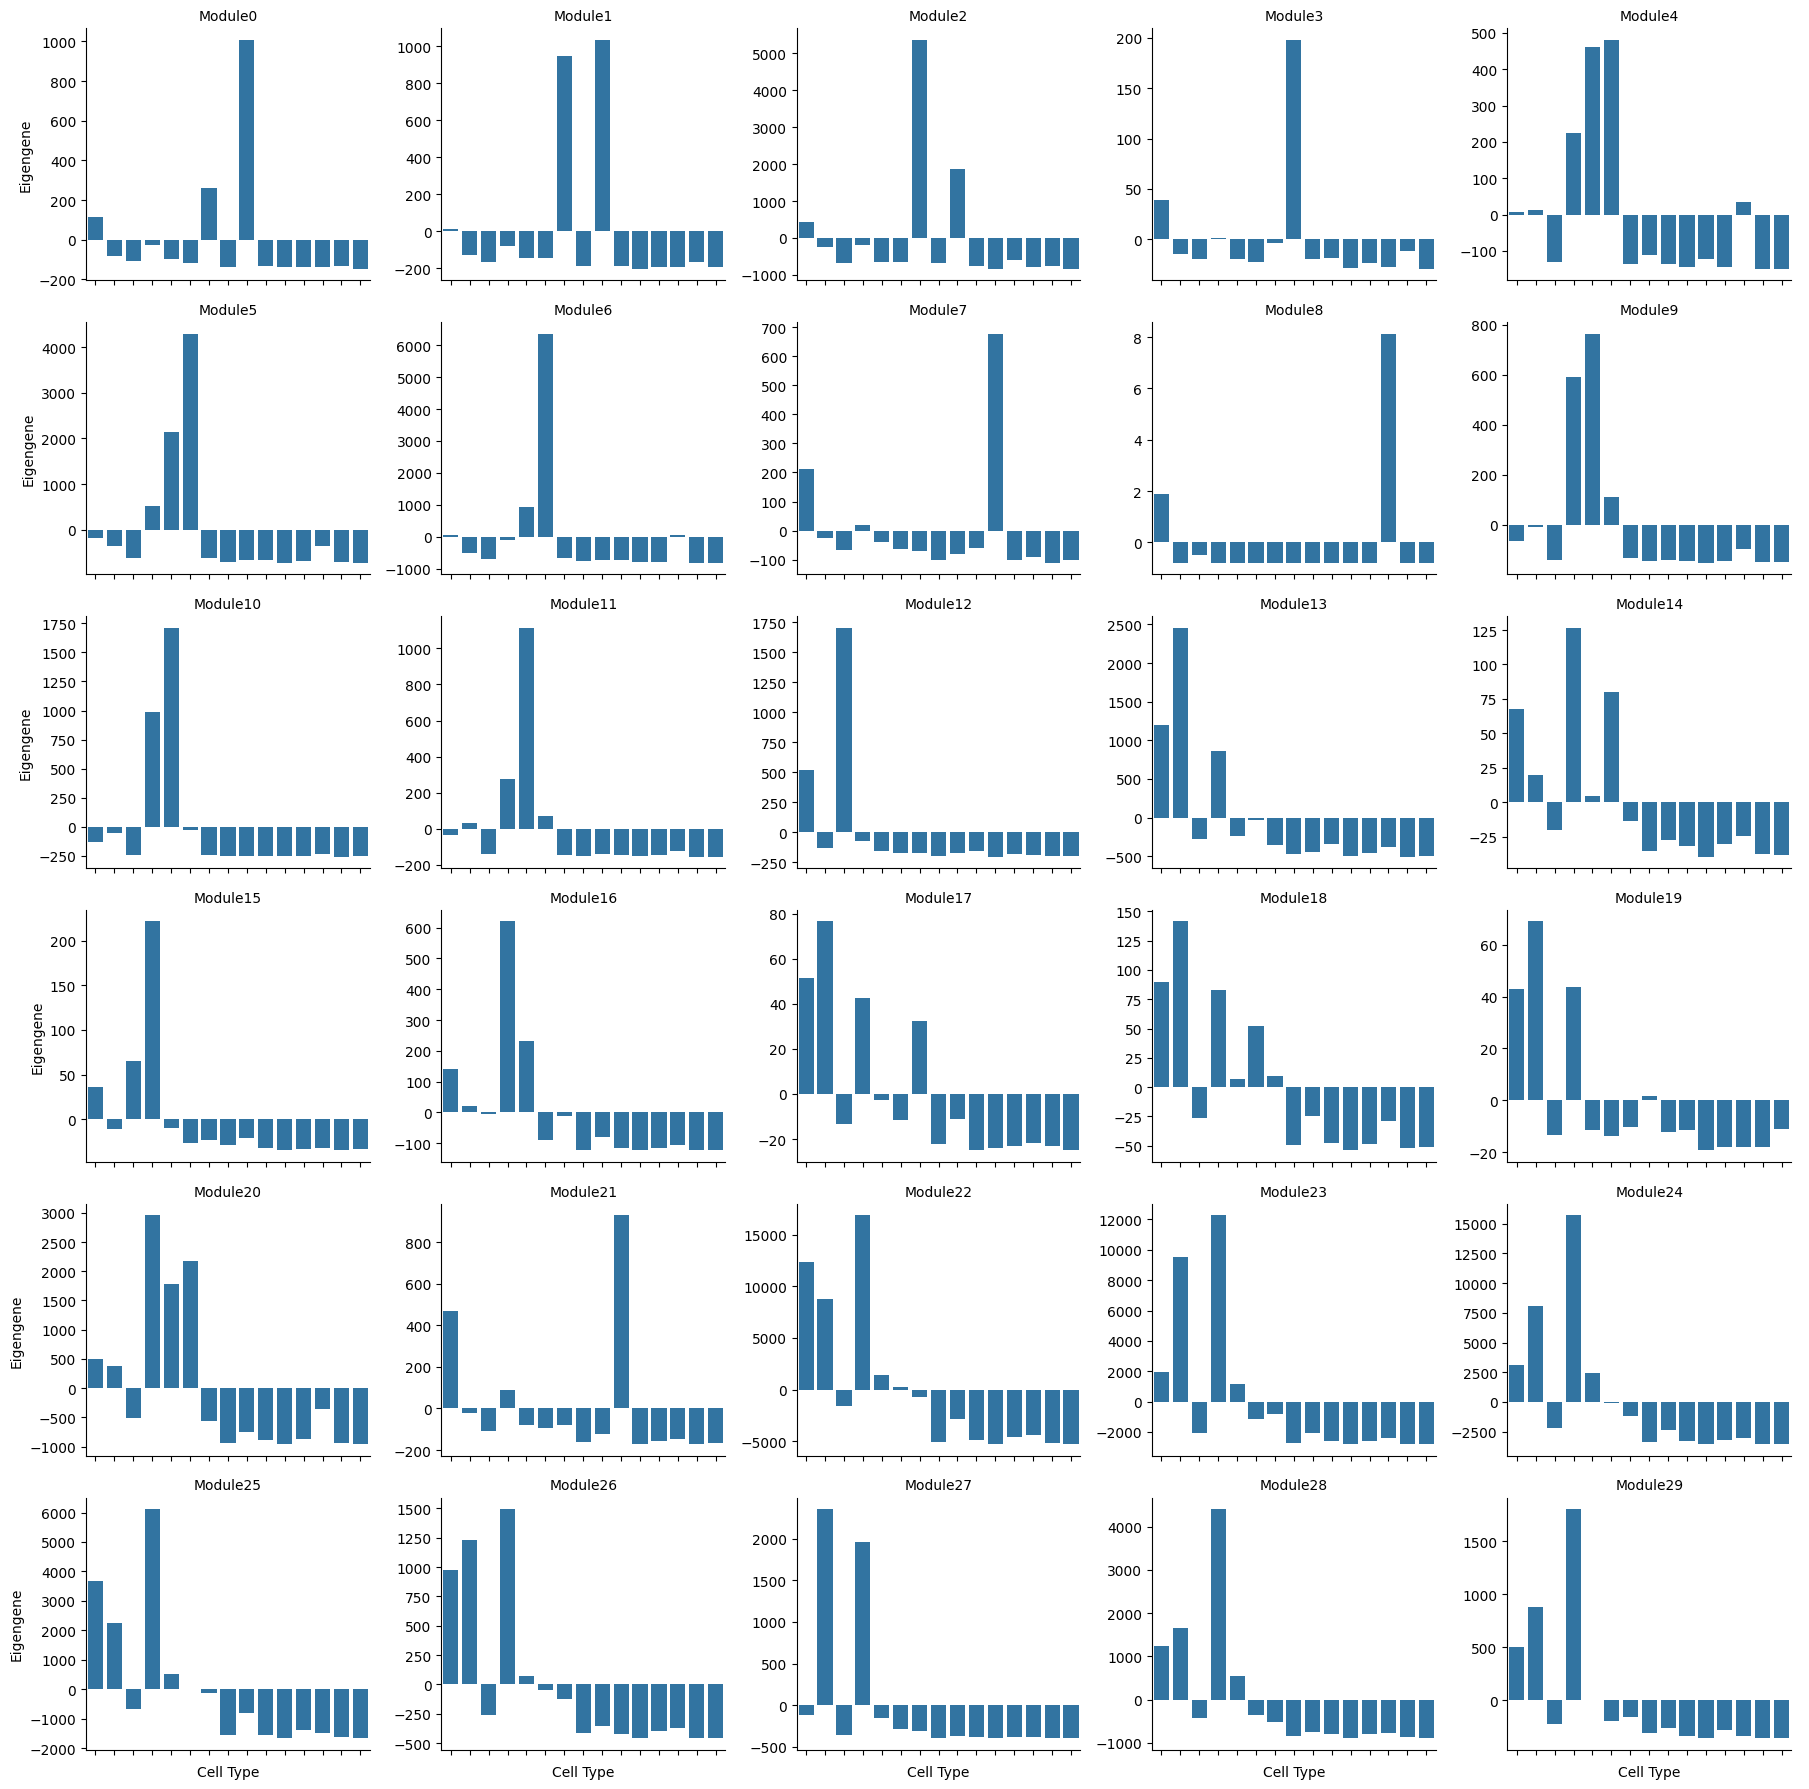

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare long-format data as before
modules_to_plot = [f"Module{m}" for m in noncoding_enriched_modules if f"Module{m}" in df_eigengenes.columns]

df_long = df_eigengenes[modules_to_plot].reset_index().melt(id_vars="index", var_name="Module", value_name="Eigengene")
df_long.rename(columns={"index": "Cell Type"}, inplace=True)

# Plot with FacetGrid
g = sns.catplot(
    data=df_long,
    x="Cell Type", y="Eigengene",
    col="Module", col_wrap=5,  # 5 plots per row
    kind="bar", height=3, aspect=1.2, sharey=False
)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()


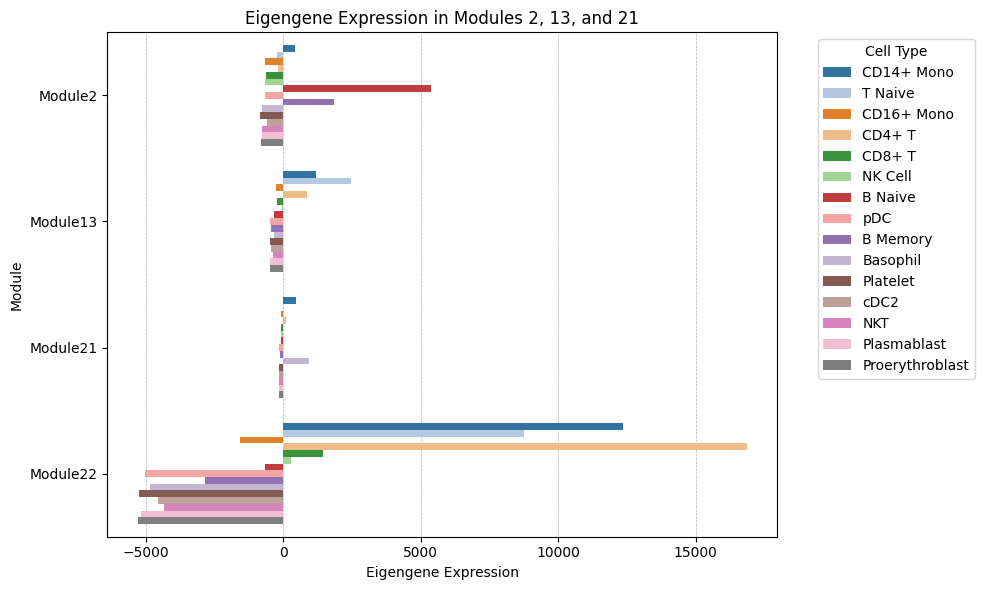

In [36]:


# If you want to use the same order as before (most abundant → least)
plot_order = adata.obs['cell_type_lvl2'].value_counts().index.tolist()
# Use the same palette as in the original barplot
celltype_palette = sns.color_palette("tab20", n_colors=len(plot_order))

# Map cell types to colors
celltype_color_dict = dict(zip(plot_order, celltype_palette))

# Explicitly list the modules you want to plot
selected_module_ids = [2, 13, 21, 22]
modules_to_plot = [f"Module{m}" for m in selected_module_ids if f"Module{m}" in df_eigengenes.columns]

# Melt for plotting
df_long = df_eigengenes[modules_to_plot].reset_index().melt(
    id_vars="index", var_name="Module", value_name="Eigengene"
)
df_long.rename(columns={"index": "Cell Type"}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_long,
    x="Eigengene",
    y="Module",
    hue="Cell Type",
    palette="tab20"
)

plt.title("Eigengene Expression in Modules 2, 13, and 21")
plt.xlabel("Eigengene Expression")
plt.ylabel("Module")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(axis='x', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


In [37]:
#import urllib.request
#import gzip
#import shutil
#url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
#urllib.request.urlretrieve(url, "go-basic.obo")

# Step 1: Download the compressed file
#url = "https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz"
#urllib.request.urlretrieve(url, "gene2go.gz")

# Step 2: Decompress it
#with gzip.open("gene2go.gz", "rb") as f_in:
#    with open("gene2go", "wb") as f_out:
#        shutil.copyfileobj(f_in, f_out)

#print(" gene2go downloaded and extracted.")



# Prepare GO tools and names


In [38]:
from collections import defaultdict
import mygene

def prepare_goatools_inputs(module_series, background_gene_names, species='human'):
    """
    Map genes to Entrez IDs for GOATOOLS compatibility.

    Parameters:
    - module_series: pd.Series, index = gene names, values = module IDs
    - background_gene_names: list of all genes in the expression matrix
    - species: 'human' or 'mouse', default is 'human'

    Returns:
    - module_entrez_dict: dict {module_id: [entrez_gene1, ...]}
    - background_entrez: list of Entrez IDs for all background genes
    - mapping_table: DataFrame showing mapping results (symbol → Entrez)
    """
    mg = mygene.MyGeneInfo()

    # Combine study + background genes for bulk query
    all_genes = list(set(module_series.index).union(set(background_gene_names)))

    # Try multiple naming conventions
    gene_info = mg.querymany(all_genes, scopes=['symbol', 'ensembl.gene'], fields='entrezgene', species=species)

    # Create mapping table
    mapping_table = {
        entry['query']: entry.get('entrezgene')
        for entry in gene_info if 'entrezgene' in entry
    }

    # Convert module -> Entrez
    module_entrez_dict = defaultdict(list)
    for gene, module in module_series.items():
        entrez = mapping_table.get(gene)
        if entrez:
            module_entrez_dict[module].append(entrez)

    # Convert background to Entrez
    background_entrez = [
        mapping_table[gene]
        for gene in background_gene_names if gene in mapping_table
    ]

    # Wrap mapping table in DataFrame
    import pandas as pd
    mapping_df = pd.DataFrame([
        {"input": entry['query'], "entrez": entry.get('entrezgene')}
        for entry in gene_info
    ])

    print(f" Mapped {len(mapping_table)} / {len(all_genes)} input genes to Entrez IDs.")
    return module_entrez_dict, background_entrez, mapping_df

module_entrez_dict, background_entrez, mapping_df = prepare_goatools_inputs(
    module_series, 
    background_gene_names=df_expr.index
)

# Check output
print(mapping_df.head())

# Example: run GO enrichment for module 3
#module3_entrez = module_entrez_dict[2]


Input sequence provided is already in string format. No operation performed
1826 input query terms found dup hits:	[('SERPINB9P1', 2), ('LIMASI', 2), ('LINC00900', 2), ('STIM2-AS1', 2), ('ARHGEF18-AS1', 2), ('LINC01
1704 input query terms found no hit:	['MRPS36', 'Y_RNA-143', 'Y_RNA-157', 'ARMT1', 'Asn_tRNA-11', 'ENSG00000250948', 'ENSG00000283633', '


 Mapped 26738 / 36849 input genes to Entrez IDs.
             input entrez
0             CFTR   1080
1           OR10D3  26497
2            GRSF1   2926
3  ENSG00000235288   None
4  ENSG00000287732   None


In [ ]:
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.go_enrichment import GOEnrichmentStudy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

def go_results_to_df(results, fdr_thresh=0.2, top_n=20):
    sorted_results = sorted(results, key=lambda r: r.p_fdr_bh)
    filtered = [r for r in sorted_results if r.p_fdr_bh < fdr_thresh and r.study_count > 0]

    if not filtered:
        print(f" No results passed FDR < {fdr_thresh} with study hits.")
        return pd.DataFrame()

    top_results = filtered[:top_n]

    df = pd.DataFrame([{
        'GO Term': r.name,
        'GO ID': r.GO,
        'Namespace': r.NS,
        'Study Count': r.study_count,
        'Study Total': r.study_n,
        'Pop Count': r.pop_count,
        'Pop Total': r.pop_n,
        'p-value': r.p_uncorrected,
        'FDR': r.p_fdr_bh,
        '-log10(FDR)': -np.log10(r.p_fdr_bh + 1e-10),
        '-log10(p-value)': -np.log10(r.p_uncorrected + 1e-10),
    } for r in top_results if r.study_count > 0])

    return df  



def plot_combined_go_bars(df_go, module_id, gene_list, top_n=20):
    if df_go.empty:
        print(f"No enriched terms to display for module {module_id}.")
        return

    df_go = df_go.sort_values("-log10(FDR)", ascending=True).tail(top_n)

    fig, axes = plt.subplots(1, 2, figsize=(16, max(6, 0.4 * len(df_go))), sharey=True)

    # Plot -log10(FDR)
    sns.barplot(data=df_go, x='-log10(FDR)', y='GO Term', palette='viridis', ax=axes[0])
    axes[0].set_title(f"Module {module_id} - FDR")
    axes[0].set_xlabel("-log10(FDR)")
    axes[0].set_ylabel("")
    axes[0].axvline(1.301, color='red', linestyle='--', label='FDR = 0.05')
    axes[0].legend()

    # Plot -log10(p-value)
    df_go_sorted_pval = df_go.sort_values("-log10(p-value)", ascending=True)
    sns.barplot(data=df_go_sorted_pval, x='-log10(p-value)', y='GO Term', palette='magma', ax=axes[1])
    axes[1].set_title(f"Module {module_id} - p-value")
    axes[1].set_xlabel("-log10(p-value)")
    axes[1].set_ylabel("")

    # Add genes as annotation below the plots
    gene_text = ", ".join(gene_list)
    gene_text_wrapped = textwrap.fill(gene_text, width=140)

    fig.suptitle(f"GO Enrichment for Module {module_id}", fontsize=16)
    fig.subplots_adjust(top=0.85, bottom=0.25)
    fig.text(0.5, 0.05, f"Genes in Module {module_id}:\n{gene_text_wrapped}", 
             ha='center', va='center', fontsize=9, wrap=True)

    plt.tight_layout(rect=[0, 0.15, 1, 0.9])
    plt.show()


# Load GO DAG and gene2go annotation
obodag = GODag("go-basic.obo")
reader = Gene2GoReader("gene2go", taxids=[9606])
geneid2gos = reader.get_id2gos(namespace='BP')  # You can change to 'MF' or 'CC'

# Prepare background
background_ids = [int(g) for g in background_entrez]

# Prepare GOEA engine once
#goea = GOEnrichmentStudy(
#    background_ids,
#    geneid2gos,
#    obodag,
#    propagate_counts=True,
#    methods=['fdr_bh']
#)

goea = GOEnrichmentStudy(
    background_ids,         # previously called pop_ids
    geneid2gos,             # Entrez ID -> GO terms (BP)
    obodag,                  # parsed from go-basic.obo
    propagate_counts=True,
    alpha=0.05,
    methods=['fdr_bh'],
    min_overlap=3,          # optional, reduces noise
    min_num_genes=20        # optional, filters out rare GO terms
)
# Store results here
all_go_results = {}
all_go_dataframes = {}



# Plot for specific modules only


Runing  Ontology Analysis: current study set of 69 IDs.
 64%     44 of     69 study items found in association
100%     69 of     69 study items found in population(26738)
Calculating 14,658 uncorrected p-values using fisher_scipy_stats


  14,658 terms are associated with 16,897 of 26,738 population items
   1,206 terms are associated with     44 of     69 study items
  METHOD fdr_bh:
      18 GO terms found significant (< 0.05=alpha) ( 18 enriched +   0 purified): statsmodels fdr_bh
      20 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


/tmp/ipykernel_2220/3630705186.py:44: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(biotypes):
/tmp/ipykernel_2220/3630705186.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_go, x='-log10(FDR)', y='GO Term', palette='magma', ax=ax1)
/tmp/ipykernel_2220/3630705186.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(bio_df['Biotype'], rotation=90)


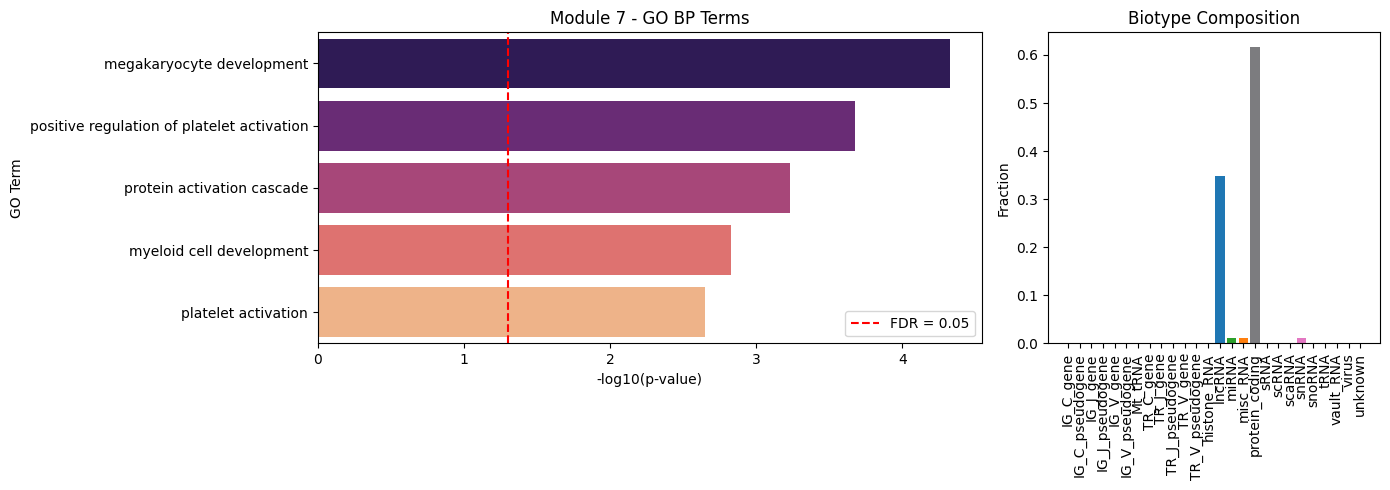

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Biotype colors
biotype_colors = {
    'lncRNA': '#1f77b4',
    'misc_RNA': '#ff7f0e',
    'miRNA': '#2ca02c',
    'snoRNA': '#d62728',
    'tRNA': '#9467bd',
    'scaRNA': '#8c564b',
    'snRNA': '#e377c2',
    'histone_RNA': '#17BECF',
    'protein_coding': '#7c7c7f'
}

target_modules = [7]#, 7, 13, 21]

for module_id in target_modules:
    gene_list = module_entrez_dict.get(module_id)
    gene_symbols = module_series[module_series == module_id].index.tolist()

    if not gene_list or len(gene_list) < 10:
        print(f"Skipping module {module_id} (insufficient genes)")
        continue

    # --- GO ANALYSIS ---
    study_ids = [int(g) for g in gene_list]
    results = goea.run_study(study_ids)
    all_go_results[module_id] = results

    top_by_pval = sorted(results, key=lambda r: r.p_uncorrected)[:5]
    df_go = pd.DataFrame([{
        'GO Term': r.name,
        '-log10(p-value)': -np.log10(r.p_uncorrected + 1e-10),
        'FDR': r.p_fdr_bh,
        '-log10(FDR)': -np.log10(r.p_fdr_bh + 1e-10)
    } for r in top_by_pval if r.study_count > 0])

    # --- BIOTYPE FRACTIONS ---
    biotypes = adata.var.loc[gene_symbols, 'biotype']
    if pd.api.types.is_categorical_dtype(biotypes):
        if 'unknown' not in biotypes.cat.categories:
            biotypes = biotypes.cat.add_categories(['unknown'])
    biotypes = biotypes.fillna('unknown')
    biotype_counts = biotypes.value_counts(normalize=True)

    # --- PLOT ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # GO barplot
    if not df_go.empty:
        sns.barplot(data=df_go, x='-log10(FDR)', y='GO Term', palette='magma', ax=ax1)
        ax1.set_title(f"Module {module_id} - GO BP Terms")
        #ax1.axvline(1.301, color='red', linestyle='--', label='FDR = 0.05')
        fdr_threshold = -np.log10(0.05)
        ax1.axvline(fdr_threshold, color='red', linestyle='--', label='FDR = 0.05')
        ax1.legend()
        ax1.set_xlabel("-log10(p-value)")
    else:
        ax1.set_title(f"Module {module_id} - No GO Terms")
        ax1.axis("off")

    # Biotype barplot
    bio_df = pd.DataFrame({
        'Biotype': biotype_counts.index,
        'Fraction': biotype_counts.values
    }).sort_values('Biotype')

    ax2.bar(
        x=bio_df['Biotype'],
        height=bio_df['Fraction'],
        color=[biotype_colors.get(bt, 'gray') for bt in bio_df['Biotype']]
    )
    ax2.set_xticklabels(bio_df['Biotype'], rotation=90)
    ax2.set_ylabel("Fraction")
    ax2.set_title("Biotype Composition")

    plt.tight_layout()
    plt.show()


In [53]:
import numpy as np

# Extract uncorrected p-values from GOATOOLS results
pvals = np.array([r.p_uncorrected for r in results])
m = len(pvals)  # total number of tests
alpha = 0.05

# Sort p-values and compute BH threshold
sorted_indices = np.argsort(pvals)
sorted_pvals = pvals[sorted_indices]
ranks = np.arange(1, m + 1)  # 1-based

# BH threshold line
bh_thresholds = (ranks / m) * alpha

# Find the largest p-value where p <= BH threshold
below_thresh = sorted_pvals <= bh_thresholds
if any(below_thresh):
    max_idx = np.where(below_thresh)[0].max()
    p_thresh = sorted_pvals[max_idx]
    print(f"FDR 0.05 corresponds to uncorrected p-value threshold: {p_thresh:.2e}")
else:
    print("No p-values pass FDR < 0.05")


FDR 0.05 corresponds to uncorrected p-value threshold: 2.81e-05



Runing  Ontology Analysis: current study set of 146 IDs.
 67%     98 of    146 study items found in association
100%    146 of    146 study items found in population(26738)
Calculating 14,658 uncorrected p-values using fisher_scipy_stats
  14,658 terms are associated with 16,897 of 26,738 population items
   1,640 terms are associated with     98 of    146 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


/tmp/ipykernel_2220/3786404356.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(biotypes):
/tmp/ipykernel_2220/3786404356.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2220/3786404356.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


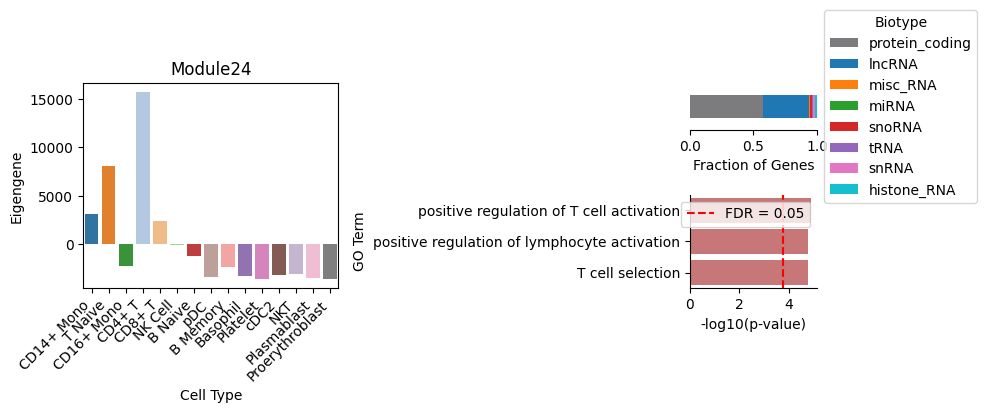

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Define biotype color map (only these will be shown)
selected_biotypes = {
    'protein_coding': '#7c7c7f',
    'lncRNA': '#1f77b4',
    'misc_RNA': '#ff7f0e',
    'miRNA': '#2ca02c',
    'snoRNA': '#d62728',
    'tRNA': '#9467bd',
    'scaRNA': '#8c564b',
    'snRNA': '#e377c2',
    'histone_RNA': '#17BECF'
    
}

target_modules = [24] #,5,7,13,21]

for module_id in target_modules:
    gene_list = module_entrez_dict.get(module_id)
    gene_symbols = module_series[module_series == module_id].index.tolist()

    if not gene_list or len(gene_list) < 10:
        print(f"Skipping module {module_id} (insufficient genes)")
        continue

    # --- GO ANALYSIS ---
    study_ids = [int(g) for g in gene_list]
    results = goea.run_study(study_ids)
    all_go_results[module_id] = results

    top_by_pval = sorted(results, key=lambda r: r.p_uncorrected)[:3]
    df_go = pd.DataFrame([{
        'GO Term': r.name,
        '-log10(p-value)': -np.log10(r.p_uncorrected + 1e-10),
        'FDR': r.p_fdr_bh
    } for r in top_by_pval if r.study_count > 0])

    # --- BIOTYPE STACKED BAR ---
    biotypes = adata.var.loc[gene_symbols, 'biotype']
    if pd.api.types.is_categorical_dtype(biotypes):
        if 'unknown' not in biotypes.cat.categories:
            biotypes = biotypes.cat.add_categories(['unknown'])
    biotypes = biotypes.fillna('unknown')

    filtered = biotypes[biotypes.isin(selected_biotypes.keys())]
    biotype_counts = filtered.value_counts(normalize=True)

    # Ensure all selected biotypes are included, even if 0
    biotype_fractions = pd.Series({
        bt: biotype_counts.get(bt, 0.0) for bt in selected_biotypes.keys()
    })

    # --- PLOT ---
    #fig, (ax1, ax2, ax3) = plt.subplots(
    #1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1, 1.5]})

    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=(10, 4))
    gs = GridSpec(nrows=2, ncols=2, width_ratios=[2, 1], height_ratios=[1, 2], figure=fig)

    ax1 = fig.add_subplot(gs[1, 1])  # GO enrichment (top-left)
    ax2 = fig.add_subplot(gs[0, 1])  # Biotype composition (bottom-left)
    ax3 = fig.add_subplot(gs[:, 0])  # Eigengene bar (entire right column)


    # GO barplot
    if not df_go.empty:
        sns.barplot(data=df_go, x='-log10(p-value)', y='GO Term', color='#D46A6A', ax=ax1) #EC5B57
        #ax1.set_title(f"Module {module_id} - GO BP Terms")
        ax1.axvline(3.76, color='red', linestyle='--', label='FDR = 0.05')
        ax1.legend()
        ax1.set_xlabel("-log10(p-value)")
    else:
        #ax1.set_title(f"Module {module_id} - No GO Terms")
        ax1.axis("off")

    # Remove box/spines
    for spine in ["top", "right"]:
        ax1.spines[spine].set_visible(False)

    # Horizontal stacked bar for biotypes
    left = 0
    bar_height = 0.5  # thin bar
    for bt, frac in biotype_fractions.items():
        ax2.barh(
            y=0, 
            width=frac, 
            left=left, 
            height=bar_height, 
            color=selected_biotypes[bt]
        )
        left += frac

    # Clean up plot
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.5, 0.5)  # center thin bar
    ax2.set_yticks([])       # remove y ticks
    ax2.set_yticklabels([])  # remove y labels
    #ax2.set_title("Biotype Composition")
    ax2.set_xlabel("Fraction of Genes")

    # Remove box/spines
    for spine in ["top", "right", "left"]:
        ax2.spines[spine].set_visible(False)

    # Create legend for biotypes
    legend_elements = [
        Patch(facecolor=color, label=bt) for bt, color in selected_biotypes.items() if biotype_fractions[bt] > 0
    ]
    ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Biotype")


        # --- EIGENGENE PLOT (3rd panel) ---
    module_col = f"Module{module_id}"
    if module_col in df_eigengenes.columns:
        eigengene_df = df_eigengenes[[module_col]].reset_index()
        eigengene_df.columns = ['Cell Type', 'Eigengene']
        
        sns.barplot(data=eigengene_df, x='Cell Type', y='Eigengene', ax=ax3, color='gray')
        # Add color column using mapping
        eigengene_df['Color'] = eigengene_df['Cell Type'].map(celltype_color_dict)

        # Sort for consistent order
        eigengene_df['Cell Type'] = pd.Categorical(eigengene_df['Cell Type'], categories=plot_order, ordered=True)
        eigengene_df = eigengene_df.sort_values('Cell Type')

      # Plot with manual color
        sns.barplot(
          data=eigengene_df,
          x='Cell Type',
          y='Eigengene',
          palette=eigengene_df['Color'].tolist(),
          ax=ax3
        )

        ax3.set_title(f"Module{module_id}")
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    else:
        ax3.set_title("No Eigengene Data")
        ax3.axis("off")


    plt.tight_layout()
    plt.savefig("module24_eigengene_by_celltype.pdf", bbox_inches="tight")

    plt.show()


In [47]:
df_all = pd.DataFrame([{
    'GO ID': r.GO,
    'GO Term': r.name,
    'p_uncorrected': r.p_uncorrected,
    'FDR': r.p_fdr_bh,
    'Ratio_in_study': f"{r.study_count}/{r.study_n}",
    'Ratio_in_pop': f"{r.pop_count}/{r.pop_n}",
} for r in results if r.study_count > 0])

df_all.sort_values("FDR").head(10)


,GO ID,GO Term,p_uncorrected,FDR,Ratio_in_study,Ratio_in_pop
0,GO:0050870,positive regulation of T cell activation,0.000013,0.089019,9/146,258/26738
1,GO:0051251,positive regulation of lymphocyte activation,0.000017,0.089019,10/146,336/26738
2,GO:0045058,T cell selection,0.000018,0.089019,4/146,29/26738
3,GO:1903039,positive regulation of leukocyte cell-cell adh...,0.000025,0.090298,9/146,280/26738
4,GO:0002696,positive regulation of leukocyte activation,0.000039,0.114354,10/146,371/26738
5,GO:0050867,positive regulation of cell activation,0.000061,0.144815,10/146,391/26738
6,GO:0043368,positive T cell selection,0.000069,0.144815,3/146,15/26738
7,GO:0022409,positive regulation of cell-cell adhesion,0.000096,0.175926,9/146,334/26738
8,GO:0046629,gamma-delta T cell activation,0.000170,0.276606,3/146,20/26738
9,GO:0045061,thymic T cell selection,0.000197,0.289276,3/146,21/26738



Runing  Ontology Analysis: current study set of 146 IDs.
 67%     98 of    146 study items found in association
100%    146 of    146 study items found in population(26738)
Calculating 14,658 uncorrected p-values using fisher_scipy_stats


  14,658 terms are associated with 16,897 of 26,738 population items
   1,640 terms are associated with     98 of    146 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


/tmp/ipykernel_2220/3245479686.py:47: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(biotypes):
/tmp/ipykernel_2220/3245479686.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2220/3245479686.py:148: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


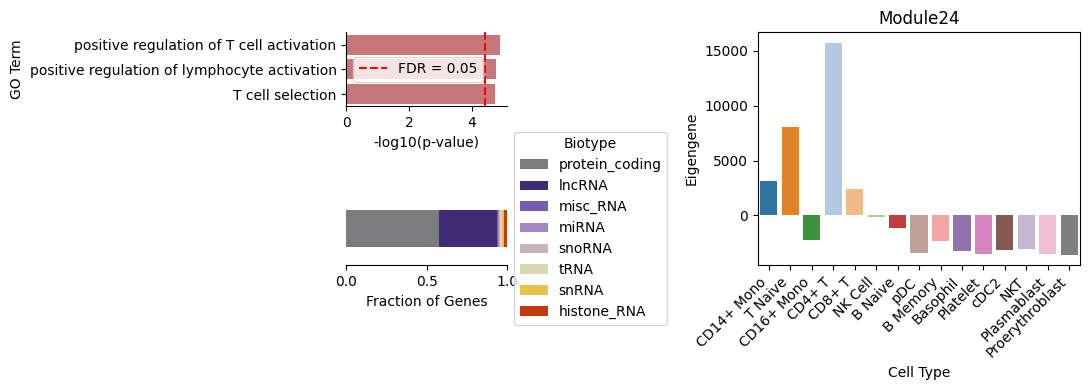

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Define biotype color map (only these will be shown)
selected_biotypes = {
    'protein_coding': '#7c7c7f',
    'lncRNA': '#412b77',
    'misc_RNA': '#745cb0',
    'miRNA': '#a388c5',
    'snoRNA': '#c7b4b9',
    'tRNA': '#dcd5b1',
    'scaRNA': '#e6e98f',
    'snRNA': '#e7c14a',
    'histone_RNA': '#c23b0e'
    
}


target_modules = [24] #,5,7,13,21]

for module_id in target_modules:
    gene_list = module_entrez_dict.get(module_id)
    gene_symbols = module_series[module_series == module_id].index.tolist()

    if not gene_list or len(gene_list) < 10:
        print(f"Skipping module {module_id} (insufficient genes)")
        continue

    # --- GO ANALYSIS ---
    study_ids = [int(g) for g in gene_list]
    results = goea.run_study(study_ids)
    all_go_results[module_id] = results

    top_by_pval = sorted(results, key=lambda r: r.p_uncorrected)[:3]
    df_go = pd.DataFrame([{
        'GO Term': r.name,
        '-log10(p-value)': -np.log10(r.p_uncorrected + 1e-10),
        'FDR': r.p_fdr_bh
    } for r in top_by_pval if r.study_count > 0])

    # --- BIOTYPE STACKED BAR ---
    biotypes = adata.var.loc[gene_symbols, 'biotype']
    if pd.api.types.is_categorical_dtype(biotypes):
        if 'unknown' not in biotypes.cat.categories:
            biotypes = biotypes.cat.add_categories(['unknown'])
    biotypes = biotypes.fillna('unknown')

    filtered = biotypes[biotypes.isin(selected_biotypes.keys())]
    biotype_counts = filtered.value_counts(normalize=True)

    # Ensure all selected biotypes are included, even if 0
    biotype_fractions = pd.Series({
        bt: biotype_counts.get(bt, 0.0) for bt in selected_biotypes.keys()
    })

    # --- PLOT ---
    #fig, (ax1, ax2, ax3) = plt.subplots(
    #1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1, 1.5]})

    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=(11, 4))
    gs = GridSpec(nrows=2, ncols=2, width_ratios=[1, 2], height_ratios=[1, 1], figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])  # GO enrichment (top-left)
    ax2 = fig.add_subplot(gs[1, 0])  # Biotype composition (bottom-left)
    ax3 = fig.add_subplot(gs[:, 1])  # Eigengene bar (entire right column)


    # GO barplot
    if not df_go.empty:
        sns.barplot(data=df_go, x='-log10(p-value)', y='GO Term', color='#D46A6A', ax=ax1) #EC5B57
        #ax1.set_title(f"Module {module_id} - GO BP Terms")
        ax1.axvline(-np.log10(3.81e))-5), color='red', linestyle='--', label='FDR = 0.05')
        ax1.legend()
        ax1.set_xlabel("-log10(p-value)")
    else:
        #ax1.set_title(f"Module {module_id} - No GO Terms")
        ax1.axis("off")

    # Remove box/spines
    for spine in ["top", "right"]:
        ax1.spines[spine].set_visible(False)

    # Horizontal stacked bar for biotypes
    left = 0
    bar_height = 0.5  # thin bar
    for bt, frac in biotype_fractions.items():
        ax2.barh(
            y=0, 
            width=frac, 
            left=left, 
            height=bar_height, 
            color=selected_biotypes[bt]
            #colors = sns.color_palette("CMRmap", n_colors=len(biotype_counts))

#
        )
        left += frac

    # Clean up plot
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.5, 0.5)  # center thin bar
    ax2.set_yticks([])       # remove y ticks
    ax2.set_yticklabels([])  # remove y labels
    #ax2.set_title("Biotype Composition")
    ax2.set_xlabel("Fraction of Genes")

    # Remove box/spines
    for spine in ["top", "right", "left"]:
        ax2.spines[spine].set_visible(False)

    # Create legend for biotypes
    legend_elements = [
        Patch(facecolor=color, label=bt) for bt, color in selected_biotypes.items() if biotype_fractions[bt] > 0
    ]
    ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Biotype")


        # --- EIGENGENE PLOT (3rd panel) ---
    module_col = f"Module{module_id}"
    if module_col in df_eigengenes.columns:
        eigengene_df = df_eigengenes[[module_col]].reset_index()
        eigengene_df.columns = ['Cell Type', 'Eigengene']
        
        sns.barplot(data=eigengene_df, x='Cell Type', y='Eigengene', ax=ax3, color='gray')
        # Add color column using mapping
        eigengene_df['Color'] = eigengene_df['Cell Type'].map(celltype_color_dict)

        # Sort for consistent order
        eigengene_df['Cell Type'] = pd.Categorical(eigengene_df['Cell Type'], categories=plot_order, ordered=True)
        eigengene_df = eigengene_df.sort_values('Cell Type')

      # Plot with manual color
        sns.barplot(
          data=eigengene_df,
          x='Cell Type',
          y='Eigengene',
          palette=eigengene_df['Color'].tolist(),
          ax=ax3
        )

        ax3.set_title(f"Module{module_id}")
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    else:
        ax3.set_title("No Eigengene Data")
        ax3.axis("off")


    plt.tight_layout()
    plt.savefig("module24_eigengene_by_celltype.pdf", bbox_inches="tight")

    plt.show()



Runing  Ontology Analysis: current study set of 69 IDs.
 64%     44 of     69 study items found in association
100%     69 of     69 study items found in population(26738)
Calculating 14,658 uncorrected p-values using fisher_scipy_stats


  14,658 terms are associated with 16,897 of 26,738 population items
   1,206 terms are associated with     44 of     69 study items
  METHOD fdr_bh:
      18 GO terms found significant (< 0.05=alpha) ( 18 enriched +   0 purified): statsmodels fdr_bh
      20 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


/tmp/ipykernel_2220/3040210547.py:47: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(biotypes):
/tmp/ipykernel_2220/3040210547.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_2220/3040210547.py:148: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


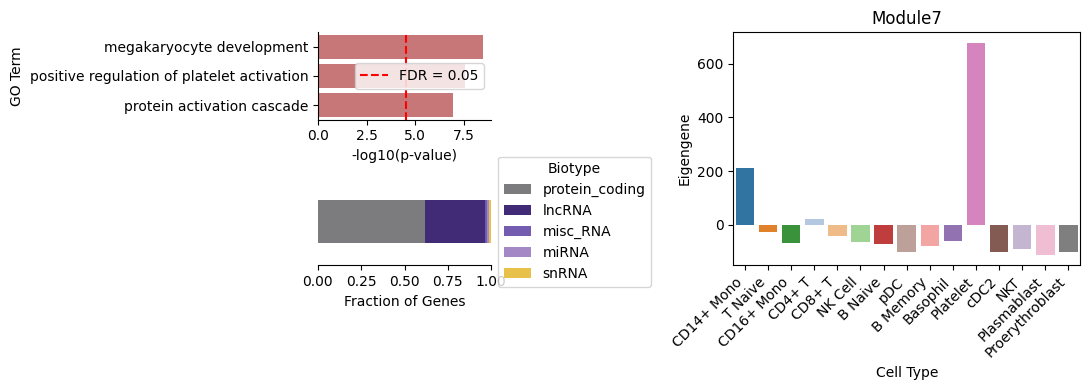

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

# Define biotype color map (only these will be shown)
selected_biotypes = {
    'protein_coding': '#7c7c7f',
    'lncRNA': '#412b77',
    'misc_RNA': '#745cb0',
    'miRNA': '#a388c5',
    'snoRNA': '#c7b4b9',
    'tRNA': '#dcd5b1',
    'scaRNA': '#e6e98f',
    'snRNA': '#e7c14a',
    'histone_RNA': '#c23b0e'
    
}


target_modules = [7] #,5,7,13,21]

for module_id in target_modules:
    gene_list = module_entrez_dict.get(module_id)
    gene_symbols = module_series[module_series == module_id].index.tolist()

    if not gene_list or len(gene_list) < 10:
        print(f"Skipping module {module_id} (insufficient genes)")
        continue

    # --- GO ANALYSIS ---
    study_ids = [int(g) for g in gene_list]
    results = goea.run_study(study_ids)
    all_go_results[module_id] = results

    top_by_pval = sorted(results, key=lambda r: r.p_uncorrected)[:3]
    df_go = pd.DataFrame([{
        'GO Term': r.name,
        '-log10(p-value)': -np.log10(r.p_uncorrected + 1e-10),
        'FDR': r.p_fdr_bh
    } for r in top_by_pval if r.study_count > 0])

    # --- BIOTYPE STACKED BAR ---
    biotypes = adata.var.loc[gene_symbols, 'biotype']
    if pd.api.types.is_categorical_dtype(biotypes):
        if 'unknown' not in biotypes.cat.categories:
            biotypes = biotypes.cat.add_categories(['unknown'])
    biotypes = biotypes.fillna('unknown')

    filtered = biotypes[biotypes.isin(selected_biotypes.keys())]
    biotype_counts = filtered.value_counts(normalize=True)

    # Ensure all selected biotypes are included, even if 0
    biotype_fractions = pd.Series({
        bt: biotype_counts.get(bt, 0.0) for bt in selected_biotypes.keys()
    })

    # --- PLOT ---
    #fig, (ax1, ax2, ax3) = plt.subplots(
    #1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1, 1.5]})

    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=(11, 4))
    gs = GridSpec(nrows=2, ncols=2, width_ratios=[1, 2], height_ratios=[1, 1], figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])  # GO enrichment (top-left)
    ax2 = fig.add_subplot(gs[1, 0])  # Biotype composition (bottom-left)
    ax3 = fig.add_subplot(gs[:, 1])  # Eigengene bar (entire right column)


    # GO barplot
    if not df_go.empty:
        sns.barplot(data=df_go, x='-log10(p-value)', y='GO Term', color='#D46A6A', ax=ax1) #EC5B57
        #ax1.set_title(f"Module {module_id} - GO BP Terms")
        ax1.axvline(-np.log10(2.81e-05), color='red', linestyle='--', label='FDR = 0.05')
        ax1.legend()
        ax1.set_xlabel("-log10(p-value)")
    else:
        #ax1.set_title(f"Module {module_id} - No GO Terms")
        ax1.axis("off")

    # Remove box/spines
    for spine in ["top", "right"]:
        ax1.spines[spine].set_visible(False)

    # Horizontal stacked bar for biotypes
    left = 0
    bar_height = 0.5  # thin bar
    for bt, frac in biotype_fractions.items():
        ax2.barh(
            y=0, 
            width=frac, 
            left=left, 
            height=bar_height, 
            color=selected_biotypes[bt]
            #colors = sns.color_palette("CMRmap", n_colors=len(biotype_counts))

#
        )
        left += frac

    # Clean up plot
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.5, 0.5)  # center thin bar
    ax2.set_yticks([])       # remove y ticks
    ax2.set_yticklabels([])  # remove y labels
    #ax2.set_title("Biotype Composition")
    ax2.set_xlabel("Fraction of Genes")

    # Remove box/spines
    for spine in ["top", "right", "left"]:
        ax2.spines[spine].set_visible(False)

    # Create legend for biotypes
    legend_elements = [
        Patch(facecolor=color, label=bt) for bt, color in selected_biotypes.items() if biotype_fractions[bt] > 0
    ]
    ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Biotype")


        # --- EIGENGENE PLOT (3rd panel) ---
    module_col = f"Module{module_id}"
    if module_col in df_eigengenes.columns:
        eigengene_df = df_eigengenes[[module_col]].reset_index()
        eigengene_df.columns = ['Cell Type', 'Eigengene']
        
        sns.barplot(data=eigengene_df, x='Cell Type', y='Eigengene', ax=ax3, color='gray')
        # Add color column using mapping
        eigengene_df['Color'] = eigengene_df['Cell Type'].map(celltype_color_dict)

        # Sort for consistent order
        eigengene_df['Cell Type'] = pd.Categorical(eigengene_df['Cell Type'], categories=plot_order, ordered=True)
        eigengene_df = eigengene_df.sort_values('Cell Type')

      # Plot with manual color
        sns.barplot(
          data=eigengene_df,
          x='Cell Type',
          y='Eigengene',
          palette=eigengene_df['Color'].tolist(),
          ax=ax3
        )

        ax3.set_title(f"Module{module_id}")
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    else:
        ax3.set_title("No Eigengene Data")
        ax3.axis("off")


    plt.tight_layout()
    plt.savefig("module7_eigengene_by_celltype.pdf", bbox_inches="tight")

    plt.show()
